# Goal: Predict the likelihood of accidents on different types of roads.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

import shap
import optuna
import joblib

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

/Users/johnny_hsieh/anaconda3/envs/n_kaggle_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

# Feature Engineering

In [2]:
def feature_engineering(df):
    df = df.copy()

    # --- 衍生邏輯特徵 ---
    df["is_highway"] = (df["road_type"] == "highway")
    df["is_dark"] = df["lighting"].isin(["dim", "night"])
    df["is_peak_hour"] = df["time_of_day"].isin(["morning", "evening"])
    df["is_bad_weather"] = df["weather"].isin(["rainy", "foggy"]) # new

    # --- 交互與比值特徵 ---
    df["lane_density"] = df["num_reported_accidents"] / (df["num_lanes"] + 1e-5) # 1e-5 避免 num_lanes 為 0 的情況下進行除法

    # --- 分段速度類別 ---
    df["speed_zone"] = pd.cut(
        df["speed_limit"],
        bins=[0, 30, 50, 70, 100],
        labels=["low", "medium", "high", "extreme"]
    )

    return df

# Data Preprocessing

In [3]:
cat_cols = [
    "road_type",
    "lighting",
    "weather",
    "time_of_day",
    "speed_zone"
]

num_cols = [
    "num_lanes",
    "curvature",
    "num_reported_accidents",
    "lane_density",
    "speed_limit"
]

bool_cols = [
    "road_signs_present",
    "public_road",
    "holiday",
    "school_season",
    "is_highway",
    "is_dark",
    "is_peak_hour",
    "is_bad_weather"
]

In [4]:
def preprocess_data(df, cat_cols, num_cols, bool_cols):
    print(f"[初始] 特徵數量：{df.shape[1]}")
    # Feature Engineering
    df = feature_engineering(df)
    print(f"[Feature Engineering] 特徵數量：{df.shape[1]}")

    # Select features and target
    target_col = "accident_risk"
    drop_cols = ["id"] 
    X = df.drop(columns=drop_cols + [target_col])
    y = df[target_col]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature Selection - Variance Threshold
    vt = VarianceThreshold(threshold=0.001)   # if variance is less than 0.01%, remove it
    X_num_bool = X_train[num_cols + bool_cols]
    vt.fit(X_num_bool)
    kept_cols = X_num_bool.columns[vt.get_support()].tolist()

    print(f"[num_cols+bool_cols] 低變異移除後特徵數量：{len(kept_cols)} / {len(X_num_bool.columns)}")
    print(f"被移除的特徵：{[c for c in X_num_bool.columns if c not in kept_cols]}")

    # Update num_cols and bool_cols based on Variance Threshold
    num_cols = [c for c in num_cols if c in kept_cols]
    bool_cols = [c for c in bool_cols if c in kept_cols]
    
    # Column Transform
    preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
        ("bool", "passthrough", bool_cols)
        ]
    )

    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    feature_names = preprocessor.get_feature_names_out()
    X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
    X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)
    print(f"[Column Transform] 最終特徵數量：{X_train_transformed.shape[1]}")

    return X_train_transformed, X_test_transformed, y_train, y_test, preprocessor

# Feature selection

## RandomForestRegressor

In [5]:
def feature_selection_rf(X_train_transformed, y_train, top_n):
    print("Modeling with RandomForestRegressor for Feature Importance...")
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train_transformed, y_train)

    importance_df = pd.DataFrame({
        "feature": X_train_transformed.columns,
        "importance": rf.feature_importances_
    }).sort_values(by="importance", ascending=False)


    top_features = importance_df.head(top_n)
    print(f"Top {top_n} features: {top_features}")
    
    plt.barh(top_features["feature"][::-1], top_features["importance"][::-1])
    plt.xlabel("Importance")
    plt.title(f"Top {top_n} Important Features (RandomForest)")
    plt.tight_layout()
    plt.show()

    selected_features = top_features["feature"].tolist()
    return selected_features

## LightGBM + SHAP

In [6]:
def feature_selection_lgbm_shap(X_train_transformed, y_train, top_n):
    print("Modeling with LightGBM Regressor for Feature Importance...")
    
    lgbm = LGBMRegressor(
        n_estimators=200, 
        random_state=42,
        learning_rate=0.05,
    )
    lgbm.fit(X_train_transformed, y_train)

    explainer = shap.TreeExplainer(lgbm)
    shap_values = explainer(X_train_transformed)

    shap_importance = pd.DataFrame({
        "feature": X_train_transformed.columns,
        "importance_shap": np.abs(shap_values.values).mean(axis=0)
    }).sort_values(by="importance_shap", ascending=False)

    print(f"Top {top_n} features: {shap_importance.head(top_n)}")
    top_features = shap_importance.head(top_n)["feature"].tolist()
    shap_values_top = shap_values[:, top_features]
    shap.summary_plot(shap_values_top, X_train_transformed[top_features], plot_type="bar", show=False)
    plt.title(f"Top {top_n} Important Features (LightGBM + SHAP")
    plt.tight_layout()
    plt.show()

    # 取欄位
    selected_features = shap_importance.head(top_n)["feature"].tolist()
    return selected_features

# Train set

In [7]:
train_df = pd.read_csv("train.csv")
train_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [9]:
train_df.iloc[0]

id                                0
road_type                     urban
num_lanes                         2
curvature                      0.06
speed_limit                      35
lighting                   daylight
weather                       rainy
road_signs_present            False
public_road                    True
time_of_day               afternoon
holiday                       False
school_season                  True
num_reported_accidents            1
accident_risk                  0.13
Name: 0, dtype: object

In [10]:
train_df.road_type.value_counts()

road_type
highway    173672
rural      172719
urban      171363
Name: count, dtype: int64

In [11]:
train_df.num_lanes.value_counts()

num_lanes
1    131168
2    130054
4    129118
3    127414
Name: count, dtype: int64

In [12]:
train_df.speed_limit.value_counts()

speed_limit
45    115752
35    111628
25    101422
60    100304
70     88648
Name: count, dtype: int64

In [13]:
train_df.lighting.value_counts()

lighting
dim         183826
daylight    178015
night       155913
Name: count, dtype: int64

In [14]:
train_df.weather.value_counts()

weather
foggy    181463
clear    179306
rainy    156985
Name: count, dtype: int64

In [15]:
train_df.time_of_day.value_counts()

time_of_day
morning      173410
evening      172837
afternoon    171507
Name: count, dtype: int64

In [16]:
train_df.describe()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849975,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


# Apply data preprocessing & feature engineering

In [17]:
X_train_transformed, X_test_transformed, y_train, y_test, preprocessor = preprocess_data(train_df, cat_cols, num_cols, bool_cols)

[初始] 特徵數量：14
[Feature Engineering] 特徵數量：20
[num_cols+bool_cols] 低變異移除後特徵數量：13 / 13
被移除的特徵：[]
[Column Transform] 最終特徵數量：28


# Apply feature selection
- Random Forest
- LightGBM + SHAP
- Total: Selected 14 Features

Modeling with RandomForestRegressor for Feature Importance...
Top 10 features:                         feature  importance
16               num__curvature    0.341475
5           cat__lighting_night    0.238430
19             num__speed_limit    0.197334
27         bool__is_bad_weather    0.039584
17  num__num_reported_accidents    0.036320
12         cat__speed_zone_high    0.033366
6            cat__weather_clear    0.027701
18            num__lane_density    0.011904
15               num__num_lanes    0.010123
20     bool__road_signs_present    0.007181


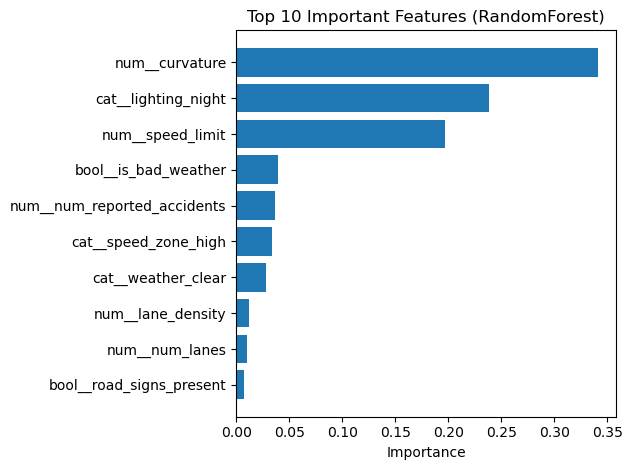

RandomForestRegressor selected features: ['num__curvature', 'cat__lighting_night', 'num__speed_limit', 'bool__is_bad_weather', 'num__num_reported_accidents', 'cat__speed_zone_high', 'cat__weather_clear', 'num__lane_density', 'num__num_lanes', 'bool__road_signs_present']


In [18]:
filtered_rf = feature_selection_rf(X_train_transformed, y_train, top_n=10)

print(f"RandomForestRegressor selected features: {filtered_rf}")

Modeling with LightGBM Regressor for Feature Importance...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 28
[LightGBM] [Info] Start training from score 0.352605
Top 10 features:                         feature  importance_shap
16               num__curvature         0.082079
12         cat__speed_zone_high         0.078812
5           cat__lighting_night         0.075872
6            cat__weather_clear         0.039079
17  num__num_reported_accidents         0.010209
19             num__speed_limit         0.001309
7            cat__weather_foggy         0.000846
3        cat__lighting_daylight         0.000830
8            cat__weather_rainy         0.000653
22                bool__holi

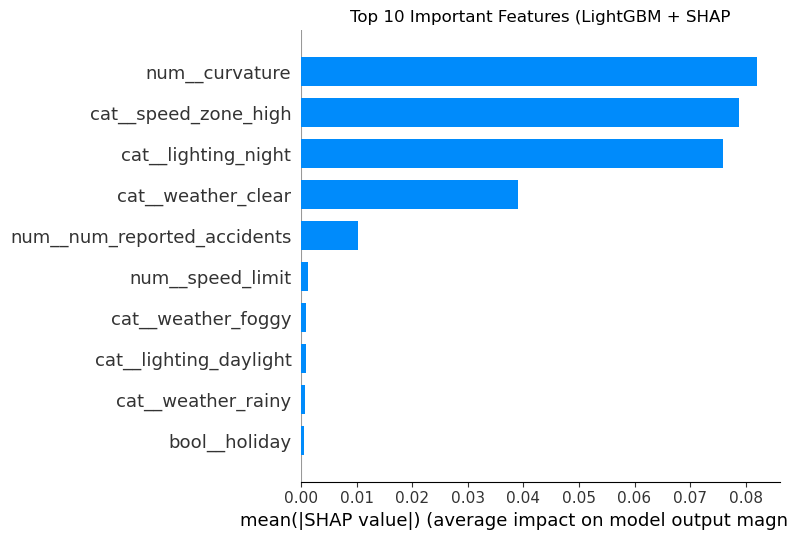

LightGBM + SHAP selected features: ['num__curvature', 'cat__speed_zone_high', 'cat__lighting_night', 'cat__weather_clear', 'num__num_reported_accidents', 'num__speed_limit', 'cat__weather_foggy', 'cat__lighting_daylight', 'cat__weather_rainy', 'bool__holiday']


In [19]:
filtered_lgbm_shap = feature_selection_lgbm_shap(X_train_transformed, y_train, top_n=10)

print(f"LightGBM + SHAP selected features: {filtered_lgbm_shap}")

In [20]:
print(f"Top 10 features from Decision Tree: {filtered_rf}")
print(f"Top 10 features from Random Forest: {filtered_lgbm_shap}")

Top 10 features from Decision Tree: ['num__curvature', 'cat__lighting_night', 'num__speed_limit', 'bool__is_bad_weather', 'num__num_reported_accidents', 'cat__speed_zone_high', 'cat__weather_clear', 'num__lane_density', 'num__num_lanes', 'bool__road_signs_present']
Top 10 features from Random Forest: ['num__curvature', 'cat__speed_zone_high', 'cat__lighting_night', 'cat__weather_clear', 'num__num_reported_accidents', 'num__speed_limit', 'cat__weather_foggy', 'cat__lighting_daylight', 'cat__weather_rainy', 'bool__holiday']


In [21]:
diff_col = len(set(filtered_rf) ^ set(filtered_lgbm_shap))
print(f"There are {diff_col} different features between Random Forest and LightGBM Top 10 features.")
print(set(filtered_rf) ^ set(filtered_lgbm_shap))

There are 8 different features between Random Forest and LightGBM Top 10 features.
{'bool__is_bad_weather', 'bool__road_signs_present', 'num__num_lanes', 'bool__holiday', 'cat__lighting_daylight', 'cat__weather_rainy', 'cat__weather_foggy', 'num__lane_density'}


In [22]:
final_features = list(set(filtered_rf) | set(filtered_lgbm_shap))
print(f"Final selected features (union): {final_features}")
print(f"Total selected features count: {len(final_features)}")

Final selected features (union): ['bool__is_bad_weather', 'num__curvature', 'bool__road_signs_present', 'cat__lighting_night', 'cat__weather_rainy', 'cat__weather_foggy', 'cat__weather_clear', 'bool__holiday', 'cat__speed_zone_high', 'num__num_lanes', 'num__num_reported_accidents', 'cat__lighting_daylight', 'num__lane_density', 'num__speed_limit']
Total selected features count: 14


In [23]:
X_train_selected = X_train_transformed[final_features]
X_test_selected = X_test_transformed[final_features]

# Modeling

In [24]:
class LightGBMTrainer:
    def __init__(self, n_splits, n_trials, random_state):
        self.n_splits = n_splits
        self.n_trials = n_trials
        self.random_state = random_state
        self.best_model = None
        self.best_params = None
        self.study = None

    # ===============================
    # Training Phase
    # ===============================
    def train_with_optuna(self, X_train_selected, y_train):
        print("Utilize Optuna + LightGBM + K-Fold for training...")

        def objective(trial):
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 2000, 5000),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
                "max_depth": trial.suggest_int("max_depth", 3, 12),
                "num_leaves": trial.suggest_int("num_leaves", 31, 255),
                "random_state": self.random_state
            }

            kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
            rmse_scores = []

            for train_idx, val_idx in kf.split(X_train_selected):
                X_tr, X_val = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                model = LGBMRegressor(**params)
                model.fit(
                    X_tr, y_tr,
                    eval_set=[(X_val, y_val)],
                    eval_metric="rmse",
                )

                y_pred = model.predict(X_val)
                rmse = np.sqrt(mean_squared_error(y_val, y_pred))
                rmse_scores.append(rmse)

            return np.mean(rmse_scores)

        # Optuna 最佳化
        self.study = optuna.create_study(direction="minimize")
        self.study.optimize(objective, n_trials=self.n_trials, show_progress_bar=True)
        self.best_params = self.study.best_params
        print()
        print("\nBest parameters")
        print(self.best_params)
        print(f"Best RMSE: {self.study.best_value:.6f}")

        # 使用最佳參數訓練最終模型
        self.best_model = LGBMRegressor(**self.best_params)
        self.best_model.fit(X_train_selected, y_train)
        print("Done training!")

        return self.best_model, self.best_params
    
    # ===============================
    # Inference Phase
    # ===============================
    def predict_test(self, test_df, preprocessor, final_features, output_path):
        print("Predicting on test data...")
        test_processed = feature_engineering(test_df)
        X_test_final = preprocessor.transform(test_processed)
        X_test_final = pd.DataFrame(
            X_test_final,
            columns=preprocessor.get_feature_names_out()
        )

        X_test_final = X_test_final[final_features]
        y_pred = self.best_model.predict(X_test_final)

        submission_df = pd.DataFrame({
            "id": test_df["id"],
            "accident_risk": y_pred
        })

        submission_df.to_csv(output_path, index=False)
        print(f"Submission file saved to {output_path}")

In [ ]:
trainer = LightGBMTrainer(n_splits=5, n_trials=20, random_state=42)

best_model, best_params = trainer.train_with_optuna(X_train_selected, y_train)

In [ ]:
joblib.dump(best_model, "best_lgbm_model.pkl")

# Inference

In [25]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


In [26]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      172585 non-null  int64  
 1   road_type               172585 non-null  object 
 2   num_lanes               172585 non-null  int64  
 3   curvature               172585 non-null  float64
 4   speed_limit             172585 non-null  int64  
 5   lighting                172585 non-null  object 
 6   weather                 172585 non-null  object 
 7   road_signs_present      172585 non-null  bool   
 8   public_road             172585 non-null  bool   
 9   time_of_day             172585 non-null  object 
 10  holiday                 172585 non-null  bool   
 11  school_season           172585 non-null  bool   
 12  num_reported_accidents  172585 non-null  int64  
dtypes: bool(4), float64(1), int64(4), object(4)
memory usage: 12.5+ MB


# Export results

In [ ]:
trainer.predict_test(test_df, preprocessor, final_features, output_path="1112_baseline_process.csv")